## Regression with a Mohs Hardness Dataset

**Task**: Create a regression model to predict the Mohs hardness of a mineral

In [30]:
!pip install lightgbm
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.0/47.0 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 17.6 MB/s eta 0:00:00:00:0100:01


In [52]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import median_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import HistGradientBoostingRegressor

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import VotingRegressor

%matplotlib.inline

UsageError: Line magic function `%matplotlib.inline` not found.


In [32]:
train_dataset=pd.read_csv("/home/jupyter/kaggle-notebooks/Dataset/train.csv")
train_dataset.head()

,id,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average,Hardness
0,0,100.0,0.841611,10.0,4.8,20.612526,11.08810,2.766,1.732,0.860,0.496070,0.91457,6.0
1,1,100.0,7.558488,10.0,4.8,20.298893,12.04083,2.755,1.631,0.910,0.492719,0.71760,6.5
2,2,76.0,8.885992,15.6,5.6,33.739258,12.08630,2.828,1.788,0.864,0.481478,1.50633,2.5
3,3,100.0,8.795296,10.0,4.8,20.213349,10.94850,2.648,1.626,0.936,0.489272,0.78937,6.0
4,4,116.0,9.577996,11.6,4.8,24.988133,11.82448,2.766,1.682,0.896,0.492736,1.86481,6.0


In [33]:
train_dataset.shape

(10407, 13)

### Explore Dataset

In [36]:
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10407 entries, 0 to 10406
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     10407 non-null  int64  
 1   allelectrons_Total     10407 non-null  float64
 2   density_Total          10407 non-null  float64
 3   allelectrons_Average   10407 non-null  float64
 4   val_e_Average          10407 non-null  float64
 5   atomicweight_Average   10407 non-null  float64
 6   ionenergy_Average      10407 non-null  float64
 7   el_neg_chi_Average     10407 non-null  float64
 8   R_vdw_element_Average  10407 non-null  float64
 9   R_cov_element_Average  10407 non-null  float64
 10  zaratio_Average        10407 non-null  float64
 11  density_Average        10407 non-null  float64
 12  Hardness               10407 non-null  float64
dtypes: float64(12), int64(1)
memory usage: 1.0 MB


0. id: Unique identifier for each mineral
1. allelectrons_Total: total num of electrons in formula
2. density_Total: density of mineral
3. allelectrons_Average: average number of electrons per atom
4. val_e_Average: outermost electrons
5. atomicweight_Average: average atomic weight
6. ionenergy_Average: average energy required to move electron from an atom
7. el_neg_chi_Average: Average electro negativity(How strongly an atom attract electrons in a bond)
8. R_vdw_element_Average: average van der Waals radius of the atoms(How large an atom is)
9. R_cov_element_Average: average covalent radius of the atoms
10. zaratio_Average: average ratio of atomic number to atomic weight
11. density_Average: 
12. Hardness: Mohs hardness

In [40]:
train_dataset.isna().sum()

id                       0
allelectrons_Total       0
density_Total            0
allelectrons_Average     0
val_e_Average            0
atomicweight_Average     0
ionenergy_Average        0
el_neg_chi_Average       0
R_vdw_element_Average    0
R_cov_element_Average    0
zaratio_Average          0
density_Average          0
Hardness                 0
dtype: int64

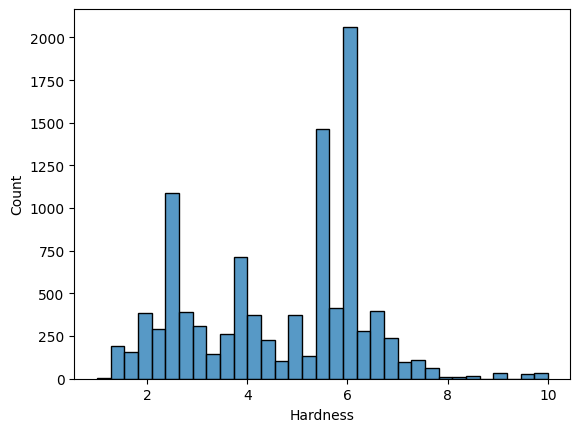

In [53]:
sns.histplot(train_dataset["Hardness"]);

In [45]:
train_dataset.corr()

,id,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average,Hardness
id,1.000000,-0.019038,-0.005849,0.001863,-0.003501,0.002035,-0.019492,-0.015554,-0.003115,0.003888,-0.013690,0.006337,-0.006989
allelectrons_Total,-0.019038,1.000000,0.616092,0.074725,0.071618,0.078489,0.034883,0.036897,0.038551,0.024420,0.031035,0.058067,-0.061687
density_Total,-0.005849,0.616092,1.000000,0.356399,0.083640,0.355614,-0.104870,-0.075535,0.202331,0.240787,-0.089792,0.336046,-0.161524
allelectrons_Average,0.001863,0.074725,0.356399,1.000000,0.004376,0.990660,-0.360046,-0.319413,0.550669,0.688680,-0.328973,0.803641,-0.400496
val_e_Average,-0.003501,0.071618,0.083640,0.004376,1.000000,0.001860,0.453901,0.550007,0.354538,0.189352,0.093854,-0.068899,0.161715
atomicweight_Average,0.002035,0.078489,0.355614,0.990660,0.001860,1.000000,-0.356640,-0.316053,0.529277,0.666165,-0.327459,0.796564,-0.402948
ionenergy_Average,-0.019492,0.034883,-0.104870,-0.360046,0.453901,-0.356640,1.000000,0.774050,0.078650,-0.235344,0.638616,-0.359735,0.203203
el_neg_chi_Average,-0.015554,0.036897,-0.075535,-0.319413,0.550007,-0.316053,0.774050,1.000000,0.121926,-0.174485,0.441195,-0.322099,0.290352
R_vdw_element_Average,-0.003115,0.038551,0.202331,0.550669,0.354538,0.529277,0.078650,0.121926,1.000000,0.811823,0.002984,0.439990,-0.061402
R_cov_element_Average,0.003888,0.024420,0.240787,0.688680,0.189352,0.666165,-0.235344,-0.174485,0.811823,1.000000,-0.221164,0.571741,-0.189111


In [59]:
# np.triu(corr)

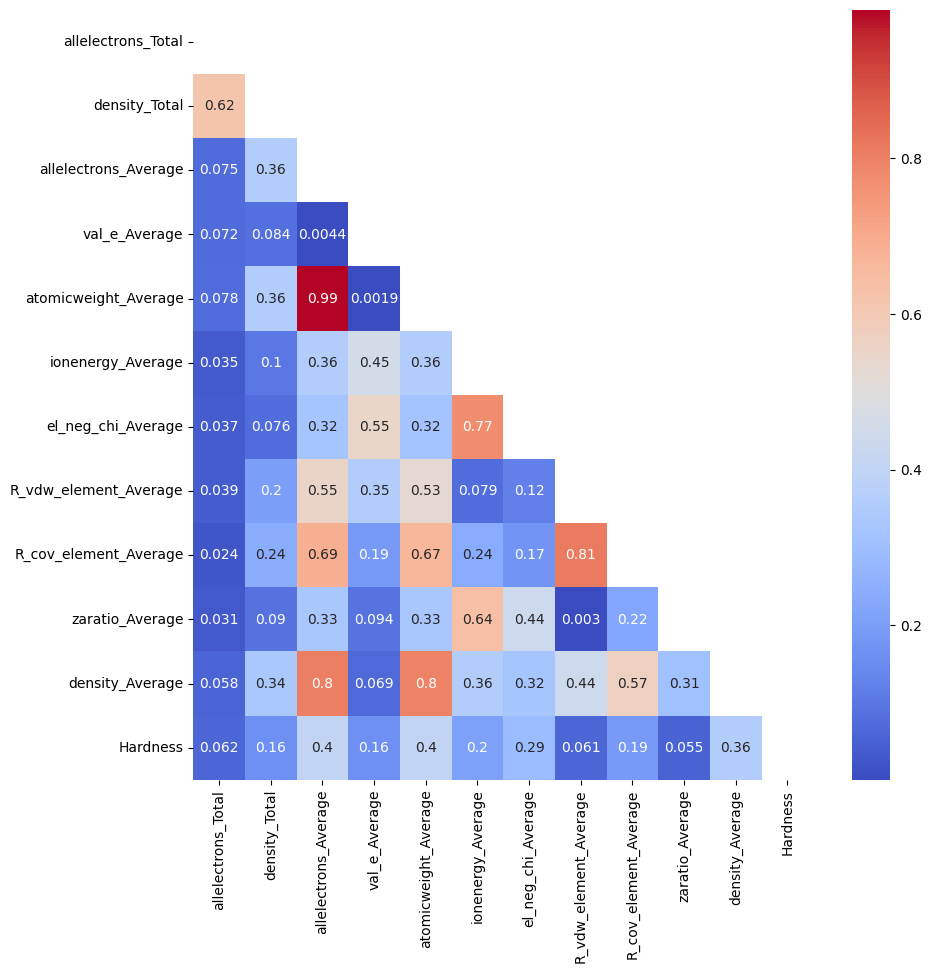

In [63]:
plt.figure(figsize=(10,10))
corr=train_dataset.drop(columns='id').corr()
sns.heatmap(abs(corr),annot=True,cmap='coolwarm',mask=np.triu(corr));
plt.show()

In [ ]:
plt.figure(figsize=(15,12))
plt.subplot(321)
sns.scatterplot(data=train_dataset,x='allelectrons_Average',y='atomicweight_Average',hue="Hardness");

plt.subplot(322)
sns.scatterplot(data=train_dataset,x='allelectrons_Average',y='density_Average',hue="Hardness");

plt.subplot(323)
sns.scatterplot(data=train_dataset,x='allelectrons_Average',y='R_vdw_element_Average',hue="Hardness");

plt.subplot(324)
sns.scatterplot(data=train_dataset,x='allelectrons_Average',y='R_cov_element_Average',hue="Hardness");

plt.subplot(325)
sns.scatterplot(data=train_dataset,x='allelectrons_Average',y='val_e_Average',hue="Hardness");